# Performance Test Conclusion

### Background

- Tested 3 dimensions of performance: **Throughput**, **IOPS**, **Latency**
- Involved 3 test platforms: **HP ProLiant DL360p Gen8 (HP)**, **Philip Kufeldt's RockPro64 (Rock64_1)** and **Jianshen Liu's RockPro64 (Rock64_2)**
- Tested 2 drives **256GB-55MS101IT9JW**, **128GB-75AS1011T9HW**, which are passed throughput and IOPS performance stability verification via comparison with other drives of the same model on Rock64_1 and Rock64_2.

  - 256GB-55MS101IT9JW @ Rock64_1 = 256GB-55MS101IT9JW @ Rock64_2 <br>
    ***(Same drive on two Rock64 platform is consistent)***
  - 128GB-75AS1011T9HW @ Rock64_1 = 128GB-75AS1011T9HW @ Rock64_2 <br>
    ***(Same drive on two Rock64 platform is consistent)***
  - 256GB-55MS101IT9JW @ Rock64_1 = 128GB-75AS1011T9HW @ Rock64_1 <br>
    ***(Two drives on the same Rock64 platform are consistent)***
  - 128GB-75AS1011T9HW @ Rock64_1 = 128GB-75AS1005T9HW @ Rock64_1 <br>
    ***(Two 128GB drives on the same Rock64 platform are consistent)***


<table>
  <caption><b>Block Size &amp; R/W Mix of Tests</b></caption>
  <tr>
    <td><b>Test</b></td>
    <td><b>Block Size &amp; R/W Mix (%)</b></td>
  </tr>
  <tr>
    <td><b>Throughput</b></td>
    <td>['4KB', '8KB', '16KB', '32KB', '128KB', '1024KB']<br>[100/0, 0/100]<br></td>
  </tr>
  <tr>
    <td><b>IOPS</b></td>
    <td>['1024KB', '128KB', '64KB', '32KB', '16KB', '8KB', '4KB', '512B']<br>[100/0, 95/5, 65/35, 50/50, 35/65, 5/95, 0/100]<br></td>
  </tr>
  <tr>
    <td><b>Latency</b></td>
    <td>['8KB', '4KB', '512B']<br>[100/0, 65/35, 0/100]</td>
  </tr>
</table>

---
* *Notes:*
  1. "=" represents performance consistency.
  2. Performance consistency means within the steady state measurement window (SSMW),
     the difference of the corresponding data point is less than **10%**.
     Each SSMW contains 5 data points.
---


### Conclusion

1. For each of the 3 test dimensions, the performance of these two drives on each of the 3 platforms is consistent.
  - 256GB-55MS101IT9JW @ Rock64_1 = 128GB-75AS1011T9HW @ Rock64_1 *(latency not tested)*
  - 256GB-55MS101IT9JW @ Rock64_2 = 128GB-75AS1011T9HW @ Rock64_2
  - 256GB-55MS101IT9JW @ HP = 128GB-75AS1011T9HW @ HP
1. Platforms comparison:
   - **Throughput**: **HP** performs better than the **Rock64** at block size 4KB and 8KB for R/W Mix 100/0 (read) and 0/100 (write) because of the performance limitation of the the BIG core on the Rock64. For all the other block sizes, **Rock64** performs better than the **HP** for both the read and write I/O patterns.
   - **IOPS**: For all R/W Mixes, the performance of these two platforms with block sizes of 512B, 4KB and 8KB is not consistent and **HP** achieves **higher** IOPS than **Rock64** platform for these 3 cases. For all the other combinations of block sizes and R/W Mixes, the values of IOPS from these two platforms are consistent. No CPU bottleneck is detected during the IOPS tests.
   - **Latency**: For all different block sizes and R/W Mixes, the **Rock64** always has **higher** latency than the **HP**. No CPU bottleneck is detected during the latency tests.

---
---
---

### **256GB-55MS101IT9JW** on HP vs. **128GB-75AS1011T9HW** on RockPro64

The following results are generated from the system testbed with the CPU scaling governor set to `performance`, thus, ensures all the online CPUs are running at the `maximum scaling frequency` (MCF). Note that the MCF is different from the `current frequency` (CF) of the CPU and the values of them may be different. On the HP system, which equipped with the Intel® Xeon® E5-2630 v2 CPU, the value of CF is different from the MCF. However, on the RockPro64 with the RK3399 CPU, these two values are the same.

We can access these values through the *cpufreq* interface within directory `/sys/devices/system/cpu/cpu0/cpufreq/`:

```
cpuinfo_cur_freq :		Current frequency of the CPU as obtained from
						the hardware, in KHz. This is the frequency
						the CPU actually runs at.

scaling_cur_freq :		Current frequency of the CPU as determined by
						the governor and cpufreq core, in KHz. This is
						the frequency the kernel thinks the CPU runs
						at.
```
Link: [Linux CPUFreq USER GUIDE](https://www.kernel.org/doc/Documentation/cpu-freq/user-guide.txt)


The RK3399 CPU uses the big.LITTLE architecture and has two CPU clusters. Normally, one runs at 1.8GHz with 2 cores and the other runs at 1.416GHz with 4 cores. To mostly exploit the performance of the drive with the RockPro64 board, we only enable the 2 big cores so as to ensure the test program and all the relevant code path are running on these cores. In the throughput and IOPS tests, we noticed the performance is bottlenecked by the big core and the performance numbers are surprisingly even worse than without any core disabled. We suspected it could be the task scheduling problem. We finally solved this problem and achieved the expected higher performance by separating the process of the test program and the interrupt handler into two different big cores.

All the result figures are shown as follows:

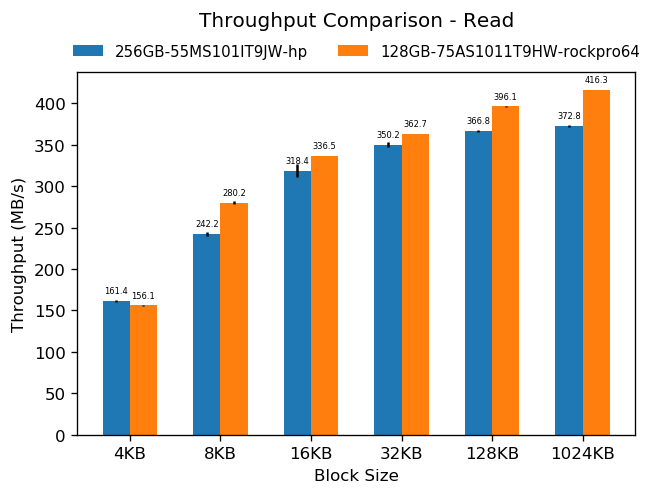

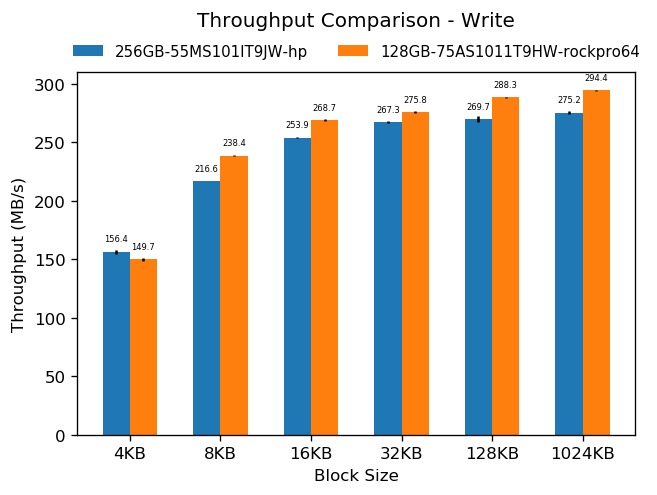

In [2]:
%run 'common/plot_throughput.py'

plot_throughput_comp({
    '256GB-55MS101IT9JW-hp':        'hp/throughput/6',
    '128GB-75AS1011T9HW-rockpro64': 'rockpro64/throughput/7'
})

RockPro64 board encounters CPU bottleneck at 4KB read and write.

---

---

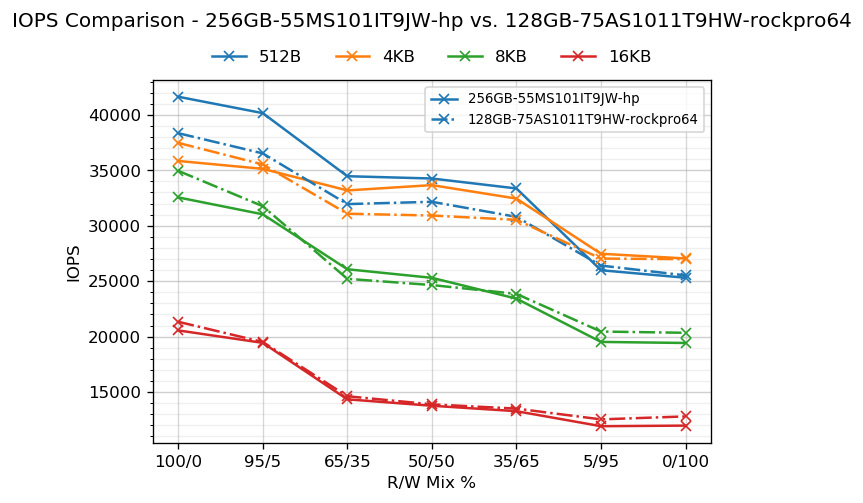

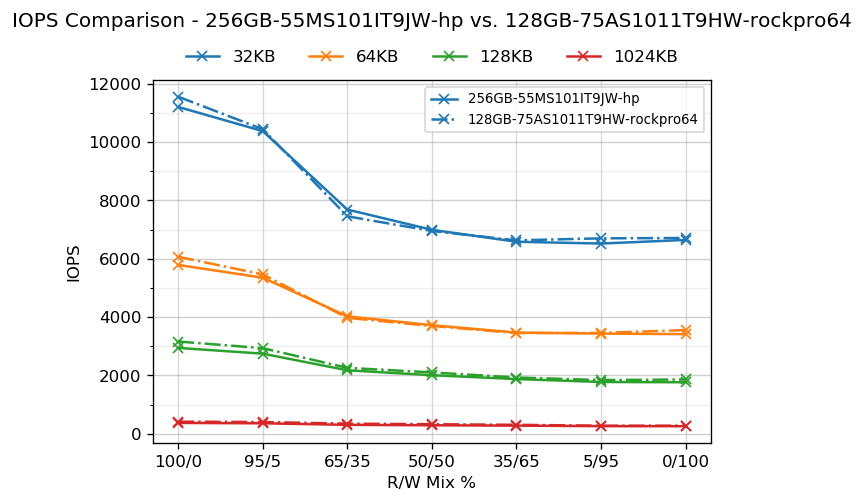

In [3]:
%run 'common/plot_iops.py'

plot_measurement_window_tabular('hp/iops/6')
plot_measurement_window_tabular('rockpro64/iops/7')

profiles = {
    '256GB-55MS101IT9JW-hp':        {_DIR: 'hp/iops/6',
                                     _MARKER: '-x'},
    '128GB-75AS1011T9HW-rockpro64': {_DIR: 'rockpro64/iops/7',
                                     _MARKER: '-.x'}
}
plot_iops_comp(profiles)

plot_diff_tabular(profiles)

We noticed that the RockPro64 board encounters CPU bottleneck starting from 4KB and smaller block sizes.

---

---

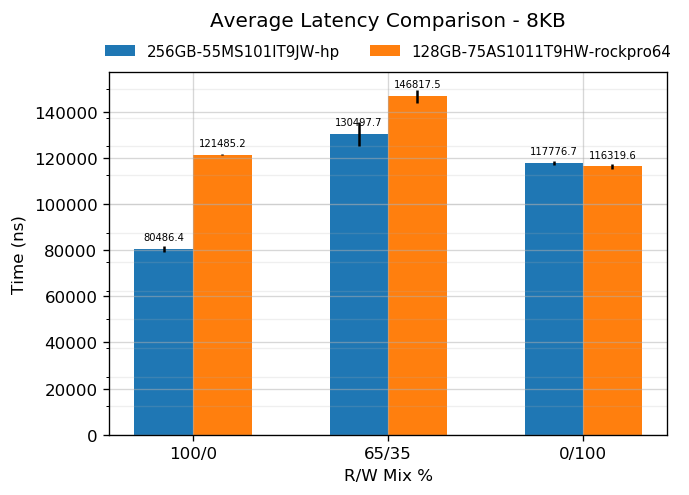

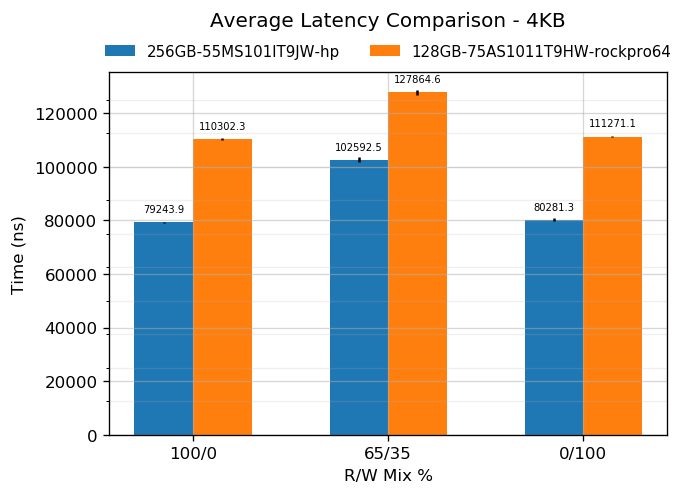

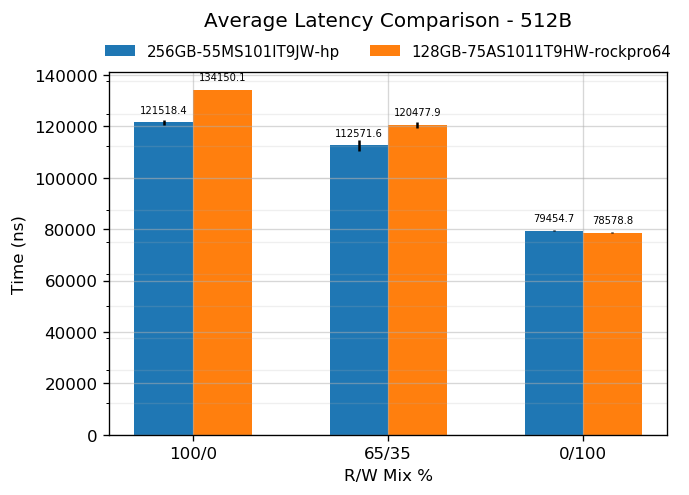

In [4]:
%run 'common/plot_lat.py'

plot_measurement_window_tabular('hp/lat/3')
plot_measurement_window_tabular('rockpro64/lat/4')

plot_lat_comp({
    '256GB-55MS101IT9JW-hp':        'hp/lat/3',
    '128GB-75AS1011T9HW-rockpro64': 'rockpro64/lat/4'
})